In [2]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import xgboost
warnings.filterwarnings('ignore')
np.random.seed(32)
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, make_scorer, recall_score, ConfusionMatrixDisplay, accuracy_score, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

c:\Users\msado\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [4]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [5]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [6]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [7]:
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [13]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95)),
    ('model', LogisticRegression())
])

In [22]:
def specificity_score(cm):
    tn, fp, fn, tp = cm.ravel() 
    return tn / (tn + fp)

In [27]:
def pipeline_fit(model):
    pipeline.set_params(model=model)
    pipeline.fit(X_train, y_train)

In [28]:
def scores_model(model):
    pipeline_fit(model)
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_scores = pipeline.predict_proba(X_train)[:, 1]
    y_test_scores = pipeline.predict_proba(X_test)[:, 1] 
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  
    test_pr_auc = auc(recall_test, precision_test)  
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm_train = confusion_matrix(y_train, y_train_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
    train_specificity = specificity_score(cfm_train)
    test_specificity = specificity_score(cfm)
    
    print("\nModel Performance:")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print(f"Training F2 Score: {train_f2:.4f}")
    print(f"Test F2 Score: {test_f2:.4f}")
    print(f"Training Specificity Score: {train_specificity:.4f}")
    print(f"Test Specificity Score: {test_specificity:.4f}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_recall, test_recall, train_f2, test_f2, train_prec, test_prec, train_specificity, test_specificity)


Model Performance:
Training Recall Score: 0.9342
Test Recall Score: 0.9261
Training F2 Score: 0.7712
Test F2 Score: 0.7686
Training Specificity Score: 0.8957
Test Specificity Score: 0.8979
Training ROC-AUC: 0.9150
Test ROC-AUC: 0.9120
Training PR-AUC: 0.8857
Test PR-AUC: 0.8862
Training Accuracy Score: 0.8990
Test Accuracy Score: 0.9003
Test Confusion Matrix:
 [[17254  1961]
 [  132  1653]]


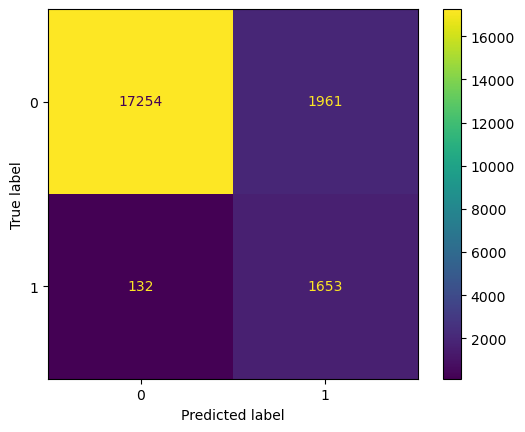

In [29]:
gboost = HistGradientBoostingClassifier(learning_rate=0.01, class_weight='balanced', random_state=32)
_ = scores_model(gboost)

Best parameters: {'min_samples_leaf': 12, 'max_features': 0.8, 'max_depth': 2}

Best model scores:

Model Performance:
Training Recall Score: 0.6639
Test Recall Score: 0.6930
Training F2 Score: 0.7117
Test F2 Score: 0.7383
Training Specificity Score: 1.0000
Test Specificity Score: 1.0000
Training ROC-AUC: 0.8319
Test ROC-AUC: 0.8465
Training PR-AUC: 0.8395
Test PR-AUC: 0.8512
Training Accuracy Score: 0.9714
Test Accuracy Score: 0.9739
Test Confusion Matrix:
 [[19215     0]
 [  548  1237]]


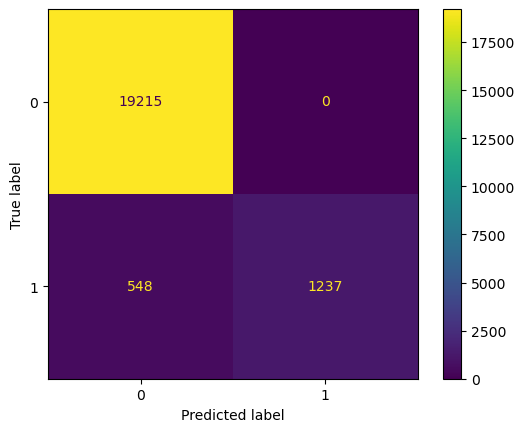

In [35]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : np.arange(0.1, 1.1, 0.1),
              "min_samples_leaf" : range(2, 20)}

scorer = make_scorer(fbeta_score)

random_search_boost = RandomizedSearchCV(estimator=gboost, param_distributions=param_dist, n_iter=50,
                                   cv=5, scoring=scorer, random_state=32)

pipeline_fit(random_search_boost)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_

print("\nBest model scores:")
_ = scores_model(boost_best)